<a href="https://colab.research.google.com/github/Jacobmunoz88/modeladoysimulacion/blob/main/proyecto_mys_JMA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis de Estabilidad de la Swing Equation Aplicada a Generadores Síncronos Conectados a una Barra Infinita**

# **DESCRIPCIÓN**

Este proyecto analiza el comportamiento dinámico del ángulo del rotor de un generador síncrono conectado a un sistema eléctrico de potencia. Cuando existe un desbalance entre la potencia mecánica suministrada y la potencia eléctrica entregada a la red, se produce un movimiento oscilatorio que puede conducir a pérdida de sincronismo. A través de la Swing Equation, se modela este fenómeno mediante un sistema dinámico no lineal de segundo orden.

Se realiza un estudio cualitativo mediante:
✅ Determinación de los puntos de equilibrio
✅ Análisis de estabilidad lineal con el Jacobiano
✅ Simulación numérica de la respuesta temporal
✅ Gráficas del plano de fases y estabilidad

Este análisis permite identificar condiciones bajo las cuales el generador permanece sincronizado, presenta oscilaciones sostenidas (ciclo límite) o pierde sincronismo, lo cual resulta esencial para el diseño y operación de sistemas eléctricos seguros y robustos.

# **MODELO ANALÍTICO**

La dinámica del rotor se representa mediante la ecuación de oscilación del generador síncrono:

$$ M \ddot{\delta} + D \dot{\delta} + P_{\text{max}} \sin(\delta) = P_m $$

donde

| Variable | Descripción |
|---|---|
| $$ \delta(t) $$ | Ángulo del rotor (rad) |
| $$ \dot{\delta}(t) $$ | Velocidad angular relativa |
| $$ M $$ | Constante de inercia |
| $$ D $$ | Coeficiente de amortiguamiento |
| $$ P_{\text{max}} $$ | Potencia máxima transmisible |
| $$ P_m $$ | Potencia mecánica de entrada |

✅ Sistema en forma de primer orden

Definiendo $$ \omega = \dot{\delta} $$:

$$
\begin{cases}
\dot{\delta} = \omega \\
\dot{\omega} = -\frac{D}{M}\omega - \frac{P_{\text{max}}}{M}\sin(\delta) + \frac{P_m}{M}
\end{cases}
$$

Para simplificar y sin pérdida de generalidad, consideramos:

$$ M=1, P_{\text{max}}=1 $$

➡️ Modelo final usado en las simulaciones:

$$
\begin{cases}
\dot{\delta} = \omega \\
\dot{\omega} = -D\omega - \sin(\delta) + P_m
\end{cases}
$$


ANÁLISIS DE ESTABILIDAD LINEAL

Punto de equilibrio 1:
   δ* = 0.9273 rad
   Jacobiano:
[[ 0.   1. ]
 [-0.6 -0.5]]
   Valores propios: λ1 = -0.2500+0.7331j, λ2 = -0.2500-0.7331j
   → ESTABLE (espiral atractora)

Punto de equilibrio 2:
   δ* = 2.2143 rad
   Jacobiano:
[[ 0.   1. ]
 [ 0.6 -0.5]]
   Valores propios: λ1 = 0.5639, λ2 = -1.0639
   → INESTABLE (silla o repulsor)


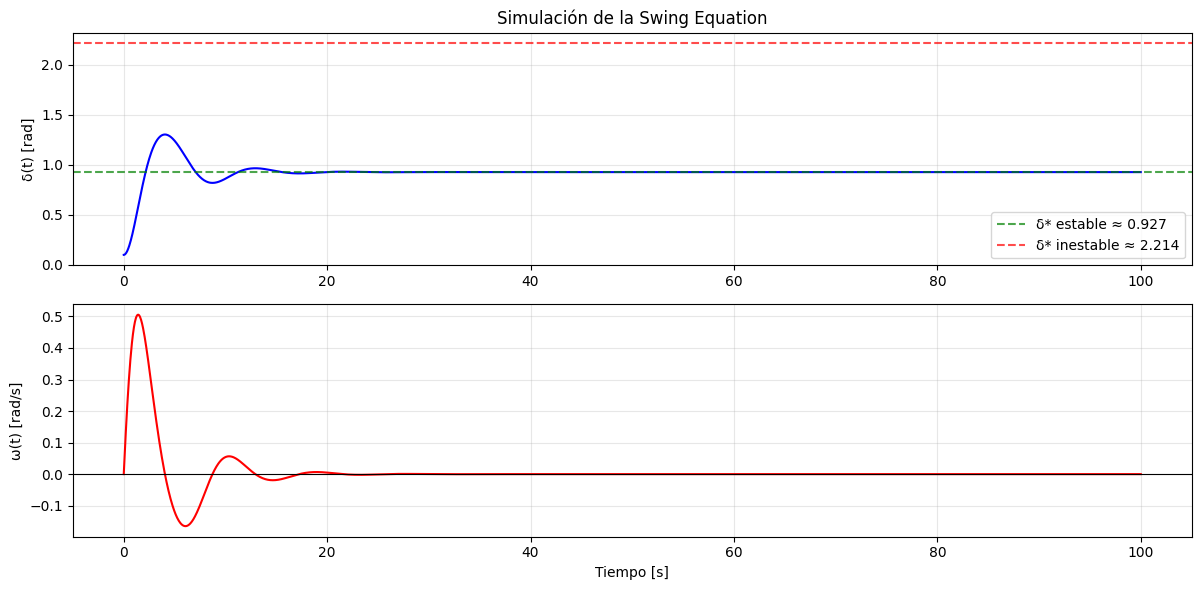

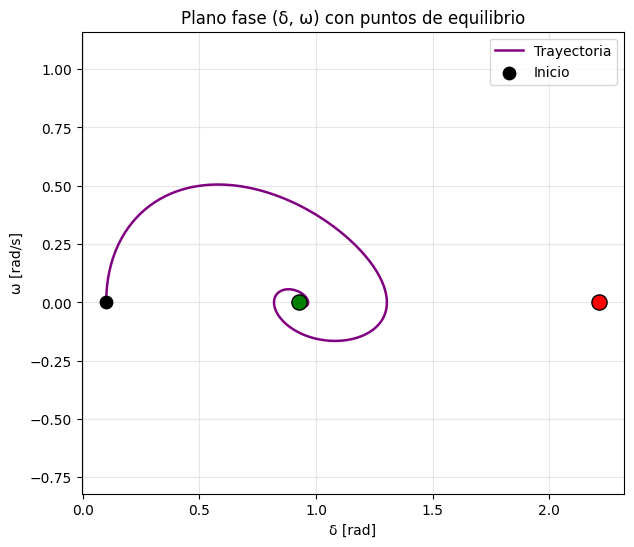

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks  # Para detectar picos (opcional)

# =====================================
# Parámetros del sistema
# =====================================
D = 0.5       # Amortiguamiento
Pm = 0.8      # Potencia mecánica
delta0 = 0.1  # Condición inicial δ
omega0 = 0.0  # Condición inicial ω

# =====================================
# Ecuación Swing (forma de primer orden)
# =====================================
def swing_equation(t, y, D, Pm):
    delta, omega = y
    ddelta_dt = omega
    domega_dt = -D * omega - np.sin(delta) + Pm
    return [ddelta_dt, domega_dt]

# =====================================
# FUNCIÓN: Jacobiano en un punto de equilibrio
# =====================================
def jacobian_at_equilibrium(delta_star, D):
    """
    Calcula el Jacobiano del sistema linealizado en δ*
    J = [[ 0,     1 ],
         [ -cos(δ*), -D ]]
    """
    J = np.array([[0.0, 1.0],
                  [-np.cos(delta_star), -D]])
    eigenvals = np.linalg.eigvals(J)
    return J, eigenvals

# =====================================
# ENCONTRAR PUNTOS DE EQUILIBRIO
# =====================================
def find_equilibria(Pm):
    """
    Resuelve sin(δ*) = Pm → δ* = arcsin(Pm) y π - arcsin(Pm)
    Solo si |Pm| <= 1
    """
    if abs(Pm) > 1.0:
        print("¡No hay equilibrio! |Pm| > 1 → rotación continua")
        return []
    else:
        alpha = np.arcsin(Pm)
        delta1 = alpha
        delta2 = np.pi - alpha
        # Normalizar al intervalo [-π, π]
        delta1 = (delta1 + np.pi) % (2*np.pi) - np.pi
        delta2 = (delta2 + np.pi) % (2*np.pi) - np.pi
        return [delta1, delta2]

# =====================================
# Simulación
# =====================================
t_span = (0, 100)
t_eval = np.linspace(0, 100, 2000)
sol = solve_ivp(swing_equation, t_span, [delta0, omega0],
                args=(D, Pm), t_eval=t_eval, method='RK45', rtol=1e-8, atol=1e-10)

# =====================================
# CÁLCULO DEL JACOBIANO EN EQUILIBRIOS
# =====================================
equilibria = find_equilibria(Pm)
print("\n" + "="*50)
print("ANÁLISIS DE ESTABILIDAD LINEAL")
print("="*50)

for i, delta_star in enumerate(equilibria):
    J, eigvals = jacobian_at_equilibrium(delta_star, D)
    print(f"\nPunto de equilibrio {i+1}:")
    print(f"   δ* = {delta_star:.4f} rad")
    print(f"   Jacobiano:\n{J}")
    print(f"   Valores propios: λ1 = {eigvals[0]:.4f}, λ2 = {eigvals[1]:.4f}")

    # Clasificación de estabilidad
    real_parts = np.real(eigvals)
    if all(real_parts < 0):
        if np.any(np.imag(eigvals) != 0):
            print("   → ESTABLE (espiral atractora)")
        else:
            print("   → ESTABLE (nodo)")
    elif any(real_parts > 0):
        print("   → INESTABLE (silla o repulsor)")
    else:
        print("   → Caso límite (necesita análisis no lineal)")

# =====================================
# Gráficas temporales
# =====================================
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(sol.t, sol.y[0], 'b', lw=1.5)
plt.axhline(equilibria[0], color='g', linestyle='--', alpha=0.7, label=f'δ* estable ≈ {equilibria[0]:.3f}')
plt.axhline(equilibria[1], color='r', linestyle='--', alpha=0.7, label=f'δ* inestable ≈ {equilibria[1]:.3f}')
plt.title('Simulación de la Swing Equation')
plt.ylabel('δ(t) [rad]')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(sol.t, sol.y[1], 'r', lw=1.5)
plt.axhline(0, color='k', linewidth=0.8)
plt.ylabel('ω(t) [rad/s]')
plt.xlabel('Tiempo [s]')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =====================================
# Plano fase + puntos de equilibrio
# =====================================
plt.figure(figsize=(7, 6))
plt.plot(sol.y[0], sol.y[1], 'purple', lw=1.8, label='Trayectoria')
plt.scatter([delta0], [omega0], color='black', s=80, zorder=5, label='Inicio')

# Marcar equilibrios
for delta_star in equilibria:
    J, eig = jacobian_at_equilibrium(delta_star, D)
    color = 'green' if np.all(np.real(eig) < 0) else 'red'
    plt.scatter(delta_star, 0, color=color, s=120, edgecolors='k', zorder=6)

plt.title('Plano fase (δ, ω) con puntos de equilibrio')
plt.xlabel('δ [rad]')
plt.ylabel('ω [rad/s]')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axis('equal')
plt.show()

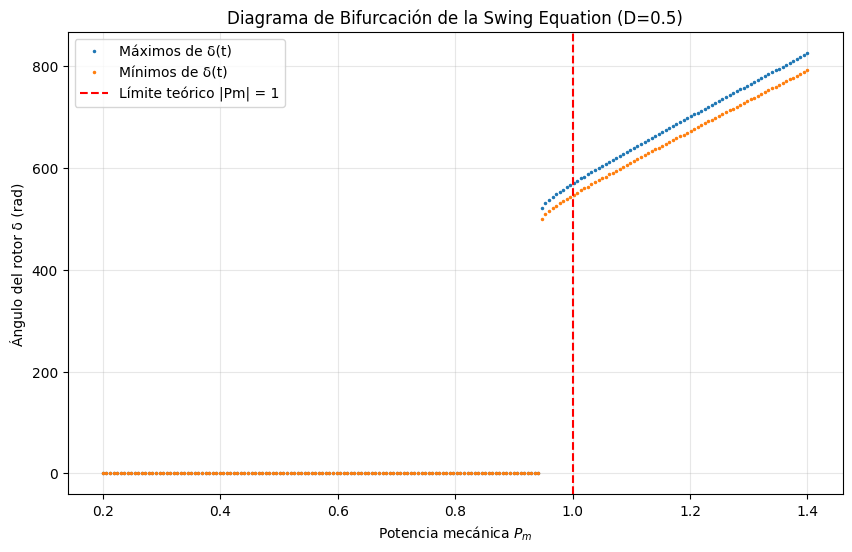

In [ ]:
# Barrido de Pm
Pm_values = np.linspace(0.2, 1.4, 200)

# Condición inicial
y0 = [0.1, 0.0]

# Listas para almacenar valores de bifurcación
delta_max = []
delta_min = []

t_eval = np.linspace(0, 300, 5000)

for Pm in Pm_values:
    sol = solve_ivp(swing_equation, (0,300), y0, args=(D,Pm),
                    t_eval=t_eval, rtol=1e-8, atol=1e-10)

    delta_values = sol.y[0][-200:]  # últimos valores (estado final)

    # Detectar oscilaciones vs equilibrio
    delta_max.append(np.max(delta_values))
    delta_min.append(np.min(delta_values))

# Graficar resultados
plt.figure(figsize=(10,6))
plt.plot(Pm_values, delta_max, '.', markersize=3, label='Máximos de δ(t)')
plt.plot(Pm_values, delta_min, '.', markersize=3, label='Mínimos de δ(t)')

plt.axvline(1.0, linestyle='--', color='r',
            label='Límite teórico |Pm| = 1')

plt.xlabel("Potencia mecánica $P_m$")
plt.ylabel("Ángulo del rotor δ (rad)")
plt.title("Diagrama de Bifurcación de la Swing Equation (D=0.5)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
